## 1. Data Preparation

### 1.1 Reading Images (Male and Female)

In [1]:
import os
import cv2
import numpy as np

# Define the path to the folder containing images
folder_path = 'C:/Users/HP/Desktop/Sem 8/DIP/Project/MIT-IB'

# Define the paths to male and female folders
male_path = os.path.join(folder_path, 'male1')
female_path = os.path.join(folder_path, 'female')

# Load male images
male_images = []
for file in os.listdir(male_path):
    img_path = os.path.join(male_path, file)
    img = cv2.imread(img_path)
    male_images.append(img)

# Load female images
female_images = []
for file in os.listdir(female_path):
    img_path = os.path.join(female_path, file)
    img = cv2.imread(img_path)
    female_images.append(img)

# Print the number of male and female images
print(f"Number of male images: {len(male_images)}")
print(f"Number of female images: {len(female_images)}")

Number of male images: 600
Number of female images: 288


### 1.2 Data Augmentation on Female Images

In [2]:
import os
import cv2
import numpy as np
import random

female_path = 'C:/Users/HP/Desktop/Sem 8/DIP/Project/MIT-IB/female'
female_aug_path = 'C:/Users/HP/Desktop/Sem 8/DIP/Project/MIT-IB/female_aug'

if not os.path.exists(female_aug_path):
    os.makedirs(female_aug_path)

# Augmentation functions
def flip_image(img):
    return cv2.flip(img, 1)

def rotate_image(img, angle):
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
    return cv2.warpAffine(img, M, (w, h))

def scale_image(img, scale):
    h, w = img.shape[:2]
    return cv2.resize(img, (int(w * scale), int(h * scale)))

# Count of new images to generate
target_total = 600
current_count = 288
needed = target_total - current_count
aug_count = 0

for file in os.listdir(female_path):
    img_path = os.path.join(female_path, file)
    img = cv2.imread(img_path)
    
    # Save original
    cv2.imwrite(os.path.join(female_aug_path, file), img)
    
    if aug_count >= needed:
        continue

    # Randomly choose 1–2 augmentations
    operations = ['flip', 'rotate', 'scale']
    chosen_ops = random.sample(operations, k=random.choice([1, 2]))

    for op in chosen_ops:
        if aug_count >= needed:
            break
        if op == 'flip':
            aug = flip_image(img)
            suffix = 'flipped'
        elif op == 'rotate':
            angle = random.choice([-20, -10, 10, 20])
            aug = rotate_image(img, angle)
            suffix = f'rotated_{angle}'
        elif op == 'scale':
            scale = random.choice([0.9, 1.1])
            aug = scale_image(img, scale)
            suffix = f'scaled_{scale}'
        
        filename = f'{file.split(".")[0]}_{suffix}.{file.split(".")[1]}'
        cv2.imwrite(os.path.join(female_aug_path, filename), aug)
        aug_count += 1

print(f"Female dataset balanced to: {current_count + aug_count} images")

# Re-load augmented female images
female_aug_path = os.path.join(folder_path, 'female_aug')
female_images = []
for file in os.listdir(female_aug_path):
    img_path = os.path.join(female_aug_path, file)
    img = cv2.imread(img_path)
    female_images.append(img)

print(f"Reloaded {len(female_images)} augmented female images")


print(len(male_images))
print(len(female_images))
print(aug_count)


Female dataset balanced to: 600 images
Reloaded 600 augmented female images
600
600
312


### 1.3 Data Preprocessing

In [3]:
def preprocess_image(img):
    # Resize to 224x224 for consistency
    img = cv2.resize(img, (224, 224))

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Enhance contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)

    # Optionally: apply Gaussian blur
    # enhanced = cv2.GaussianBlur(enhanced, (3, 3), 0)

    return enhanced


## 2. Feature Engineering

### 2.1 Low Level Features

In [4]:
from skimage.feature import hog

def extract_hog(img):
    features, _ = hog(img, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), block_norm='L2-Hys',
                      visualize=True)
    return features

from skimage.feature import local_binary_pattern

def extract_lbp(img):
    radius = 1
    n_points = 8 * radius
    lbp = local_binary_pattern(img, n_points, radius, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(),
                             bins=np.arange(0, n_points + 3),
                             range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)  # Normalize
    return hist

from skimage.feature import graycomatrix, graycoprops

def extract_glcm(img):
    glcm = graycomatrix(img, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    asm = graycoprops(glcm, 'ASM')[0, 0]
    return [contrast, dissimilarity, homogeneity, energy, correlation, asm]

def extract_low_level_features(img):
    hog_feat = extract_hog(img)
    lbp_feat = extract_lbp(img)
    glcm_feat = extract_glcm(img)
    return np.concatenate((hog_feat, lbp_feat, glcm_feat))



### 2.2 High-Level Feature Extraction (Deep Features from VGG19)

In [5]:
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

import numpy as np
import cv2

# Load pre-trained VGG19 model and extract output from 'fc2' layer
base_model = VGG19(weights='imagenet', include_top=True)
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

def extract_deep_features(img):
    # Resize image to 224x224
    img_resized = cv2.resize(img, (224, 224))

    # Convert to array and expand dimensions
    img_array = image.img_to_array(img_resized)
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocess for VGG19
    img_array = preprocess_input(img_array)

    # Get features
    features = model.predict(img_array)
    return features.flatten()


## 3. Feature Fusion and Dimensionality Reduction

### 3.1 Feature Fusion + Dataset Preparation

In [6]:
X = []
y = []

# Process Male Images
for img in male_images:
    try:
        preprocessed = preprocess_image(img)              # Grayscale for low-level
        low_feat = extract_low_level_features(preprocessed)

        high_feat = extract_deep_features(img)            # RGB for deep features

        fused = np.concatenate((low_feat, high_feat))     # Fusion
        X.append(fused)
        y.append(0)  # Label for male
    except:
        print("Error processing a male image")

# Process Female Images
for img in female_images:
    try:
        
        preprocessed = preprocess_image(img)              # Grayscale for low-level
        low_feat = extract_low_level_features(preprocessed)

        high_feat = extract_deep_features(img)            # RGB for deep features

        fused = np.concatenate((low_feat, high_feat))     # Fusion
        X.append(fused)
        y.append(1)  # Label for female
    except:
        print("Error processing a female image")

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

print(f"Final dataset shape: {X.shape}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

### 3.2 Dimensionality Reduction using PCA

### 

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)
print(f"Selected {pca.n_components_} components to retain 95% variance")


Selected 471 components to retain 95% variance


## 4. Classification using Linear SVM

### 4.1 10-Fold Cross-Validation and Model Training

In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define model
svm = SVC(kernel='linear')

# 10-fold cross-validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
y_pred = cross_val_predict(svm, X_pca, y, cv=kfold)

# Evaluation metrics
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


Accuracy:  0.8258
Precision: 0.8253
Recall:    0.8267
F1 Score:  0.8260


### 4.2 Confusion Matrix

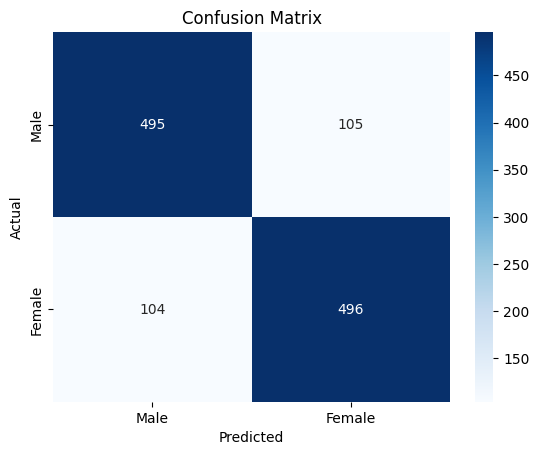

In [9]:
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
